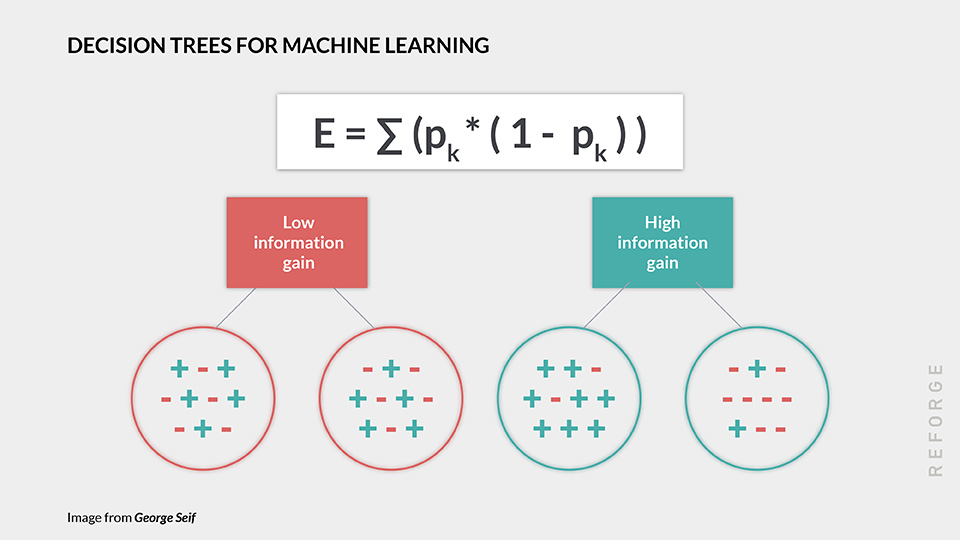

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import pickle  

In [2]:
## define a set of path: 
PATH = os.path.dirname(os.getcwd()) 
dataset_path = os.path.join(PATH, "dataset")
models_path = os.path.join(PATH, "models")

#### We add the word embeding part here
#### TO DO :  import function from other jupyter file 

In [3]:
def load_data():
    """To load data we've reated before
    """
    #TO DO:  the path must be as a param 
    data_path = os.path.join(dataset_path, "all_data.xlsx")
    data = pd.read_excel(data_path) 
    data_labels = data["labels"]  #Taking lables in separate
    print("data loaded")
    return data, data_labels

def tfidf(data):
    """Term frequency-inverse document frequency  for features extraction and transformation 
    :param data the dataset to use for word embeding .
    :type pandas dataframe
    :return tfidf model and features.
    :type spark.dataframe
    """
    # corpus = pd.DataFrame({"reviews": train_data["reviews"], "lables": train_data["lables"]})
    # corpus.reviews.append(test_data["reviews"], ignore_index=True)
    corpus = data.copy()
    dataset = spark.createDataFrame(corpus, list(corpus.columns))

    tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
    wordsData = tokenizer.transform(dataset)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    idfModel = idf.fit(featurizedData)
    rescaledData = idfModel.transform(featurizedData)
    features = rescaledData.select("features","labels")
    #save model 
    tfidf = os.path.join(models_path, "tfidf.pickle")
    pickle.dump(tfidf, open(tfidf, "wb"))
    print("tfidf model saved")
    return idfModel, features

def plot_score(model, x,y, x_label='params', y_label='score'):
    """used for visualization of data
    :param model is the model name. 
    :type string
    :param x, y : the x and y axes values  to be visualized.
    :type list 
    :param x_label is the x label name, by defaut=params.
    :type string
    :param y_label is the y label name, by defaut=score.
    :type string
    """
    plt.figure(figsize=(9, 9))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y)
    title = 'result of learning using  {}'.format(model)
    plt.suptitle(title)
    plt.show()
    
def plot_score2(x_axis, y1, y2,title, xlabels, ylabels, y1title="training score",y2title="test score",y1color='r',y2color='g'):
    """used for visualization of data
    :param x_axis the values of x axes.
    :type list
    :param y1 the values of y axes of the 1st curve.
    :type list
    :param y2 the values of y axes of the 2nd curve.
    :type list 
    :param x_label is the x label name.
    :type string
    :param y_label is the y label name.
    :type string
    :param y1title is the title of the 1st curve, by defaut="training score".
    :type string
    :param y2title is the title of the 2nd curve, by defaut="test score".
    :type string
    :param y1color is the color of the 1st curve, by defaut=red.
    :type string
    :param y2color is the color of the 2nd curve, by defaut=green.
    :type string
    """
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabels)
    plt.ylabel(ylabels)
    plt.grid()
    plt.plot(x_axis, scores_train, 'o-', color=y1color,
                 label= y1title)
    plt.plot(x_axis, scores_test, 'o-', color=y2color,
                 label=y2title)
    plt.legend(loc="best")
    plt.show()

def plot_score3(x_axis, scores_train, title, xlabels, ylabels, ytitle="training score", y2color='g'):
    """used for visualization of data
    :param x_axis the values of x axes.
    :type list
    :param score_train the values of y axes.
    :type list
    :param x_label is the x label name
    :type string
    :param y_label is the y label name
    :type string
    :param y1title is the title of the 1st curve, by defaut="training score"
    :type string
    :param y2color is the color of the 2nd curve, by defaut=green.
    :type string
    """
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabels)
    plt.ylabel(ylabels)
    plt.grid()
    plt.plot(x_axis, scores_train, 'o-', color=y2color, label= ytitle)
    #plt.plot(x_axis, scores_test, 'o-', color=y2color, label=y2title)
    plt.legend(loc="best")
    plt.show()

##### load data and use tfidf method

In [4]:
data, data_labels = load_data()
idfModel, features= tfidf(data)
features.show() 

data loaded
tfidf model saved
+--------------------+------+
|            features|labels|
+--------------------+------+
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,6,...|     1|
|(20,[0,3,4,6,7,8,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
+--------------------+------+
only showing top 20 rows



## Machine learning > Decision Tree

In [5]:
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

##### + some data treatment
##### #TO DO:  this part of must be in the preprocessing part

In [6]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True, 
    withStd= True
    ).fit(features)

df_scaled = scaler.transform(features)
df_scaled.show(5)

+--------------------+------+--------------------+
|            features|labels|      scaledFeatures|
+--------------------+------+--------------------+
|(20,[0,1,2,3,4,5,...|     1|[-0.5050488895147...|
|(20,[0,1,2,3,4,5,...|     1|[0.62957021237823...|
|(20,[0,1,2,3,4,5,...|     1|[-0.0187835601320...|
|(20,[0,1,2,3,4,5,...|     1|[-0.8292257757698...|
|(20,[0,1,2,3,4,5,...|     1|[-0.5050488895147...|
+--------------------+------+--------------------+
only showing top 5 rows



In [7]:
result_pdf = df_scaled.select('scaledFeatures').toPandas().rename(columns={"scaledFeatures": "features"})
#result_pdf.head()
transformed = result_pdf.join(df_scaled.select('labels').toPandas())
#transformed.head()
transformed = spark.createDataFrame(transformed, list(transformed.columns))
transformed.show(5)

+--------------------+------+
|            features|labels|
+--------------------+------+
|[-0.5050488895147...|     1|
|[0.62957021237823...|     1|
|[-0.0187835601320...|     1|
|[-0.8292257757698...|     1|
|[-0.5050488895147...|     1|
+--------------------+------+
only showing top 5 rows



In [8]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='labels',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)


+--------------------+------+------------+
|            features|labels|indexedLabel|
+--------------------+------+------------+
|[-0.5050488895147...|     1|         1.0|
|[0.62957021237823...|     1|         1.0|
|[-0.0187835601320...|     1|         1.0|
|[-0.8292257757698...|     1|         1.0|
|[-0.5050488895147...|     1|         1.0|
+--------------------+------+------------+
only showing top 5 rows



In [38]:
"""

cols_name = ["labels", "features"]
#3- VectorAssembler:
vector_assembler = VectorAssembler(
      inputCols = list(cols_name), outputCol = 'features'
      )
df_temp1 = vector_assembler.transform(features).select('labels','features')
df_temp1.show(3)

#4- inexation
l_indexer = StringIndexer(inputCol="Class", outputCol="labelIndex")
df_temp2 = l_indexer.fit(df_temp1).transform(df_temp1)
df_temp2.show(3)

#5- selecting features/label columns
df_temp3 = df_temp2.select('features','labelIndex')
df_temp3.show(3)
"""

'\n\ncols_name = ["labels", "features"]\n#3- VectorAssembler:\nvector_assembler = VectorAssembler(\n      inputCols = list(cols_name), outputCol = \'features\'\n      )\ndf_temp1 = vector_assembler.transform(features).select(\'labels\',\'features\')\ndf_temp1.show(3)\n\n#4- inexation\nl_indexer = StringIndexer(inputCol="Class", outputCol="labelIndex")\ndf_temp2 = l_indexer.fit(df_temp1).transform(df_temp1)\ndf_temp2.show(3)\n\n#5- selecting features/label columns\ndf_temp3 = df_temp2.select(\'features\',\'labelIndex\')\ndf_temp3.show(3)\n'

In [9]:
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features|labels|     indexedFeatures|
+--------------------+------+--------------------+
|[-0.5050488895147...|     1|[-0.5050488895147...|
|[0.62957021237823...|     1|[0.62957021237823...|
|[-0.0187835601320...|     1|[-0.0187835601320...|
|[-0.8292257757698...|     1|[-0.8292257757698...|
|[-0.5050488895147...|     1|[-0.5050488895147...|
+--------------------+------+--------------------+
only showing top 5 rows



### spliting data for training and testing

In [10]:
#spliting training and testing data + training
(trainingData, testData) = transformed.randomSplit([0.8, 0.2])
print("training data")
trainingData.show(5,True)
print("testing data")
testData.show(5,True)

training data
+--------------------+------+
|            features|labels|
+--------------------+------+
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
+--------------------+------+
only showing top 5 rows

testing data
+--------------------+------+
|            features|labels|
+--------------------+------+
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
+--------------------+------+
only showing top 5 rows



## model configuration, training and evaluation

In [11]:
#@title random forest  model
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

In [12]:
dt = DecisionTreeClassifier(labelCol="labels", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

In [14]:
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
predictions.select("prediction", "indexedLabel",'probability', "features").show(5)

+----------+------------+--------------------+--------------------+
|prediction|indexedLabel|         probability|            features|
+----------+------------+--------------------+--------------------+
|       0.0|         1.0|[0.50046772684752...|[-1.1534026620249...|
|       1.0|         1.0|[0.39428885227896...|[-1.1534026620249...|
|       1.0|         1.0|[0.39428885227896...|[-1.1534026620249...|
|       1.0|         1.0|[0.39428885227896...|[-1.1534026620249...|
|       0.0|         1.0|[0.59596530920060...|[-1.1534026620249...|
+----------+------------+--------------------+--------------------+
only showing top 5 rows



In [15]:
#@title Evaluation Decision tree (show config +)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

Test Error = 0.433039 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ee4195a46002, depth=5, numNodes=39, numClasses=2, numFeatures=20
